#  Chest X-ray Images Project Introduction from Kaggle
## for pneumonia detection with deep learning

kaggle link:
https://www.kaggle.com/tolgadincer/labeled-chest-xray-images
Context
Pneumonia is an infection that inflames the air sacs in one or both lungs. It kills more children younger than 5 years old each year than any other infectious disease, such as HIV infection, malaria, or tuberculosis. Diagnosis is often based on symptoms and physical examination. Chest X-rays may help confirm the diagnosis.

Content
This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient). For details of the data collection and description, see the referenced paper below.

According to the paper, the images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.

A previous version (v2) of this dataset is available here: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. Note that the files names are irregular in v2, but they are fixed in the new version (v3).

# Why do I select this project (in my words)
In this project,chest X-ray images from patients who are 5 years old or younger are provided. The providers are willing to determine whether there were pneumonia developments in the respiratory systems by verifying any pathological changes from the X-ray images. The CNN deep learning technique is suitable for this task because it is commonly used for image identification and classification. 



The dataset contains 1GB X-ray images
The data import and exploration processes are mainly derived from 
https://www.kaggle.com/ohstasy/detecting-pneumonia-using-deep-learning
the deep learning model is used from Wecloud lecture


In [8]:
## CNN takes a long time so that I have to transfer it from Jupyter to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
## Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
## Compare GPU with CPU
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6784917769999765
GPU (s):
0.05369769099999644
GPU speedup over CPU: 68x


In [3]:
import os
from tensorflow import keras
import seaborn as sns 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from matplotlib import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.utils import class_weight

In [4]:
#Create a function to calculate the files in a directory
def calculate_files(link):
    return (len([name for name in os.listdir(link)]))

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_normal = calculate_files('/content/drive/My Drive/Pneumonia/chest_xray/train/NORMAL')
train_pneumonia = calculate_files('/content/drive/My Drive/Pneumonia/chest_xray/train/PNEUMONIA')
test_normal = calculate_files('/content/drive/My Drive/Pneumonia/chest_xray/test/NORMAL')
test_pneumonia = calculate_files('/content/drive/My Drive/Pneumonia/chest_xray/test/PNEUMONIA')

In [7]:
#Create a dataframe with count of each class in the train dataset
train_barplot = pd.DataFrame({'number_of_images':[train_normal,train_pneumonia], 'disease':['normal', 'pneumonia']})
display(train_barplot)

,number_of_images,disease
0,1349,normal
1,3883,pneumonia


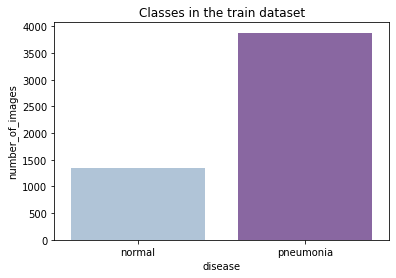

In [8]:
#Plot classes of the train dataset
sns.barplot(y = 'number_of_images', x = 'disease', 
            data = train_barplot,
            palette=("BuPu")).set_title('Classes in the train dataset');

In [9]:
#Create a dataframe with count of each class in the test dataset 
test_barplot = pd.DataFrame({'number_of_images':[test_normal,test_pneumonia], 'disease':['normal', 'pneumonia']})
display(test_barplot)

,number_of_images,disease
0,234,normal
1,390,pneumonia


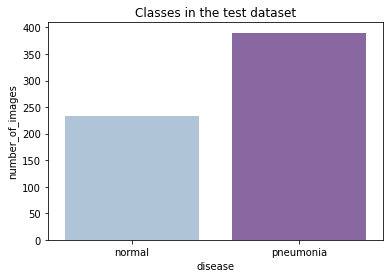

In [10]:
#Plot classes of the test dataset
sns.barplot(y = 'number_of_images', x = 'disease', 
            data = test_barplot,
            palette=("BuPu")).set_title('Classes in the test dataset');

Display Random Images


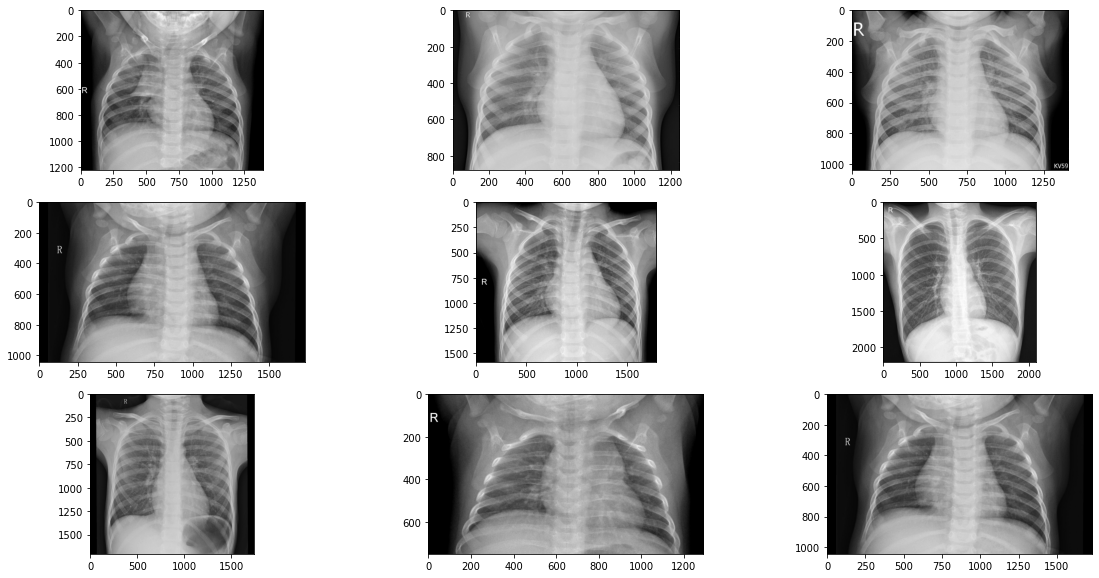

In [11]:
# Extract numpy values from Normal test/normal directory
images = [name for name in os.listdir('/content/drive/My Drive/Pneumonia/chest_xray/test/NORMAL')]

#set a pseudorandom generator to consistency
np.random.seed(42)
random_images = [np.random.choice(images, replace = False) for i in range(9)]

# Location of the image dir
img_dir = '/content/drive/My Drive/Pneumonia/chest_xray/test/NORMAL'

print('Display Random Images')

# Adjust the size of the images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(img_dir,random_images[i]))
    plt.imshow(img,cmap='gray') 

In [12]:
#Create image generators
train_datagen = ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True, # Divide each input by its standard deviation
    rotation_range=10,#Degree range for random rotations.
    width_shift_range=0.1,#fraction of total width rotation
    height_shift_range=0.1,#fraction of total height rotation
    rescale=1./255,#Scale the pixels to [0,1]
    validation_split = 0.2) #Fraction of images reserved for validation

test_datagen = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization= True, 
    rescale=1./255)

The maximum pixel value is 242.0000 and the minimum is 0.0000
The mean value of the pixels is 139.2990 and the standard deviation is 48.1488


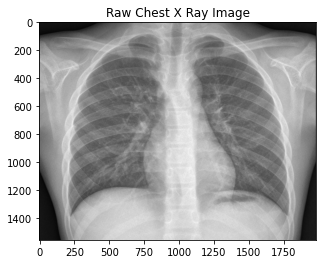

In [13]:
# Get the first image from test/normal directory
first_image = images[0]
img1 = plt.imread(os.path.join(img_dir,first_image))
plt.imshow(img1,cmap='gray')

pixels = image.imread(os.path.join(img_dir,first_image))

plt.title('Raw Chest X Ray Image')
#print(f"The dimensions of the image are {img1.width} pixels width and {img1.height} pixels height, mode of the image is {img.mode}")
print(f"The maximum pixel value is {pixels.max():.4f} and the minimum is {pixels.min():.4f}")
print(f"The mean value of the pixels is {pixels.mean():.4f} and the standard deviation is {pixels.std():.4f}")

In [14]:
#Load images in to train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/Pneumonia/chest_xray/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    subset = "training",
    seed=42
)

valid_generator = train_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/Pneumonia/chest_xray/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    subset = "validation",
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=r"/content/drive/My Drive/Pneumonia/chest_xray/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode=None,
    shuffle=False,
    seed = 42
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


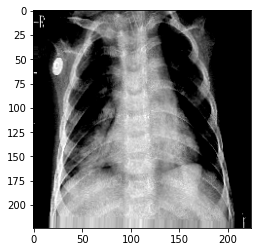

In [15]:
#Visualize a first image after preprocessing from the train set
x_train, y_train = valid_generator.__getitem__(0)
plt.imshow(x_train[0]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


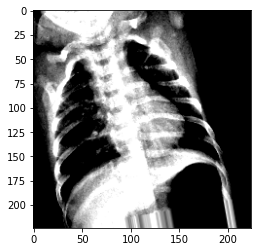

In [16]:
#Visualize a first image after preprocessing from the validation set
x_val, y_val = train_generator.__getitem__(0)
plt.imshow(x_val[0]);

In [17]:
## Obtain the bias coefficient of the train set
initial_bias = np.log([train_pneumonia/train_normal])
initial_bias

array([1.05724447])

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,SGD

In [26]:
## My CNN architecture design from scratch. This is to understand the basic mechanism
## 5 Conv-BN layers with diminishing convolution sizes and 3 finalized connection layers

inputs = keras.Input(shape= (224, 224, 3))

## 5 Conv layers used to identify the features from input images
## first layer used to identify low level features such as straight line, curve
x = Conv2D(100, (3, 3), activation='relu',padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
## second layer used to identify next level features such as elbow, circles, shapes
x = Conv2D(80, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = Conv2D(50, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = Conv2D(30, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
## last layer used to identify final features such as ribs, lung, pathological changes
x = Conv2D(10, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)


x = tf.keras.layers.Dropout(0.5)(x)

## Pooling used to pool out the highest probability for feature identification
x = GlobalAveragePooling2D()(x)

x = Flatten()(x)
## finalized connection layers
x = tf.keras.layers.Dense(128, activation='relu') (x)
x = tf.keras.layers.Dense(64, activation='relu') (x)
x = tf.keras.layers.Dense(16, activation='relu') (x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid',bias_initializer=keras.initializers.Constant(initial_bias))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=Adam(learning_rate=0.1), metrics=['Accuracy'])
## recall matrix should be used because we do not want to miss any patient

In [27]:
## model training process
## the model takes 45 mins for training

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True) ## if the error has been reduced to a certain level, the training will stop

model.fit(
        train_generator,
        steps_per_epoch=10,
        epochs=100,
        batch_size=128,
        validation_data=valid_generator,
        callbacks = early_stopping_cb,
        validation_steps=400)

Epoch 1/100
10/10 [==============================] - 80s 7s/step - loss: 1177.4138 - accuracy: 0.6733 - val_loss: 0.5716 - val_accuracy: 0.7426
Epoch 2/100
10/10 [==============================] - 24s 2s/step - loss: 17.8535 - accuracy: 0.7422
Epoch 3/100
10/10 [==============================] - 24s 2s/step - loss: 0.6037 - accuracy: 0.7094
Epoch 4/100
10/10 [==============================] - 24s 2s/step - loss: 0.6000 - accuracy: 0.7125
Epoch 5/100
10/10 [==============================] - 24s 2s/step - loss: 0.5646 - accuracy: 0.7516
Epoch 6/100
10/10 [==============================] - 24s 2s/step - loss: 0.5982 - accuracy: 0.7156
Epoch 7/100
10/10 [==============================] - 24s 2s/step - loss: 0.5778 - accuracy: 0.7359
Epoch 8/100
10/10 [==============================] - 23s 2s/step - loss: 0.5284 - accuracy: 0.7828
Epoch 9/100
10/10 [==============================] - 24s 2s/step - loss: 0.5562 - accuracy: 0.7563
Epoch 10/100
10/10 [==============================] - 24s 2s/st

In [20]:
#define a default treshold 0.5 probability for identification
def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

In [21]:
## develop a function which evaluates the model using  4 different matrices
def assess_model(model):
    predicted_vals = model.predict(test_generator, steps = len(test_generator))
    vfunc = np.vectorize(treshold)
    predictions = vfunc(predicted_vals)
    accuracy = accuracy_score(test_generator.classes, predictions)
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(test_generator.classes, predictions)
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(test_generator.classes, predictions)
    print('Precision_score : %f' % precision)
    print()
    recall = recall_score(test_generator.classes, predictions)
    print('Recall_score: %f' % recall)
    print()
    print('Confusion matrix')
    cm = confusion_matrix(y_true=test_generator.classes, y_pred=predictions)
    print(cm)

In [29]:
assess_model(model)

Accuracy: 0.625000

F1 score: 0.769231

Precision_score : 0.625000

Recall_score: 1.000000

Confusion matrix
[[  0 234]
 [  0 390]]


### The accuracy score of this CNN process is only 0.625 and it takes 45 mins for training, which is too expensive and low performed. 

another Kaggle practice used 50 Conv layers but the accuracy is only improved to 0.669
https://www.kaggle.com/felipenrocha/cnn-para-diagnosticar-pneumonia-liang-e-zheng/notebook
Therefore, here is an approach by another Kaggle practicer

Transfer learning is a technique to transfer the learning experience of a model from a large dataset and apply on our this dataset on top of it. Using this technique reduces the amount of data required and, in many cases, increases the accuracy as compared to models build from scratch.

In CNN, the first few layers only recognize general patterns like shape, edges, noise etc., and only in the later layers the network recognizes complex patterns like color, special features etc. So, we can use the first layers removing the last layers and adding our own layers to identify or predict on our own datasets.

DenseNet121
A pre-trained DenseNet121 model will be used. DenseNet121 can be loaded directly from Keras and then two layers can be added on top of it:

A GlobalAveragePooling2D layer to get the average of the last convolution layers from DenseNet121.
A Dense layer with sigmoid activation to get the prediction logits for each of our classes.
The flow for transfer learning as follows:

Take layers from a previously trained model.
Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
Train the new layers on your dataset.

In [22]:
## Transfer Learning Approach using pre-trained DenseNet121 Model
## DenseNet121 Model
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', input_shape= (224, 224, 3), include_top=False)

#freeze the base model.
base_model.trainable = False

inputs = keras.Input(shape= (224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation = 'sigmoid', 
                             bias_initializer=keras.initializers.Constant(initial_bias)
)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=keras.metrics.Recall())

29097984/29084464 [==============================] - 0s 0us/step


In [23]:
## The training takes 10mins only
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

model.fit(train_generator, 
          validation_data=valid_generator,
          steps_per_epoch=100,      
          validation_steps=400, 
          callbacks = early_stopping_cb,
          epochs = 1000)

Epoch 1/1000
100/100 [==============================] - 726s 7s/step - loss: 0.3528 - recall: 0.9656 - val_loss: 0.2391 - val_recall: 0.9575


In [24]:
assess_model(model)

Accuracy: 0.841346

F1 score: 0.882002

Precision_score : 0.824053

Recall_score: 0.948718

Confusion matrix
[[155  79]
 [ 20 370]]


The result shows an accuracy rate of 0.948, which is promising.A better practice can even reach 0.98.
https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution

However, for medical practices, the requirement for equiment or devices are strict. Based on my estimation, the accuracy of the model needs to be above 99% to replace the role of a human (doctor). However, at this stage, the CNN screening can be used for pre-process or education.

The application of CNN in scanning chest X-ray images and determining pneumonia would substantially help improve our current health care system during both emergency and regular periods.

In regular times,the time cost of healthcare service is especially important in developing countries where a doctor needs to consult 20-30 patients a day in average. The X-Ray image identification shall facilitate the doctors in disease dignostic processes, leading to a faster medical service.

In emergency times, like during the early stage of the Convid-19 pandemic, as no quick scanning test (PCR) was invented, doctors relied on chest X-ray imaging to distinguish Convid-19. Since hospitals are full of patients await for treatments and doctors and nurses are working under overwhelmed pressure, CNN technique shall effectively take the burden from the doctors and thus saving more time for those who need immediate cares.

In this study,instead of the Convid-19, the CNN is applied to the detection of pneumonia from children under 5 years old. However, the CNN deep learning mentality can be used in many other chest symptom identification processes